## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import community as community_louvain
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
from networkx.drawing.nx_agraph import graphviz_layout 
from collections import Counter

In [2]:
import pandas as pd
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [3]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [4]:
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

In [5]:
data_path = 'Movies.csv'  
data = pd.read_csv(data_path)

## Downsampling the Dataset 

In [6]:
unique_user_ids = data['userId'].unique()
unique_movie_ids = data['movieId'].unique()

fraction_users = 0.3  
fraction_movies = 0.3 

sampled_user_ids = random.sample(list(unique_user_ids), int(fraction_users * len(unique_user_ids)))
sampled_movie_ids = random.sample(list(unique_movie_ids), int(fraction_movies * len(unique_movie_ids)))
filtered_data = data[(data['userId'].isin(sampled_user_ids)) & (data['movieId'].isin(sampled_movie_ids))]

B = nx.from_pandas_edgelist(filtered_data, 'userId', 'movieId', ['genres', 'title','rating'])
connected_components = nx.number_connected_components(B)
print(f"The number of connected components in the Downsampled graph are: {connected_components}")
sampled_edges = nx.to_pandas_edgelist(B)

output_path = 'output_file.csv'  
sampled_edges.to_csv(output_path, index=False)
print(f"Thde new sampled data has been saved to: {output_path}")

The number of connected components in the Downsampled graph are: 111
Thde new sampled data has been saved to: output_file.csv


## Performing Basic Network Analysis 

In [7]:
data = pd.read_csv('output_file.csv')  
data.head()

,source,target,title,rating,genres
0,91,590,Dances with Wolves (1990),4.5,Adventure|Drama|Western
1,91,1719,"Sweet Hereafter, The (1997)",3.0,Drama
2,91,2628,Star Wars: Episode I - The Phantom Menace (1999),3.5,Action|Adventure|Sci-Fi
3,91,8958,Ray (2004),4.5,Drama
4,91,27803,"Sea Inside, The (Mar adentro) (2004)",5.0,Drama


In [8]:
B = nx.from_pandas_edgelist(data, 'source', 'target')  

number_of_nodes = B.number_of_nodes()
print(f"Number of Nodes in the data: {number_of_nodes}")
number_of_edges = B.number_of_edges()
print(f"Number of Edges in the data: {number_of_edges}")

Number of Nodes in the data: 6279
Number of Edges in the data: 19939


In [9]:
print("Density of Graph:",nx.density(B))

Density of Graph: 0.0010116297081129415


(0.0010116297081129415, 0.0037066470306960056)

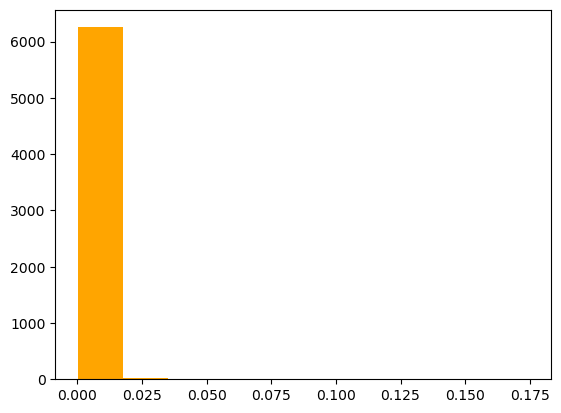

In [10]:
centrality_degree = nx.degree_centrality(B)
# print("Centrality of graph:",centrality_degree)
plt.hist(centrality_degree.values(),color='orange')
np.mean(list(centrality_degree.values())), np.std(list(centrality_degree.values()))

(0.0004185288348740648, 0.0042797882048782555)

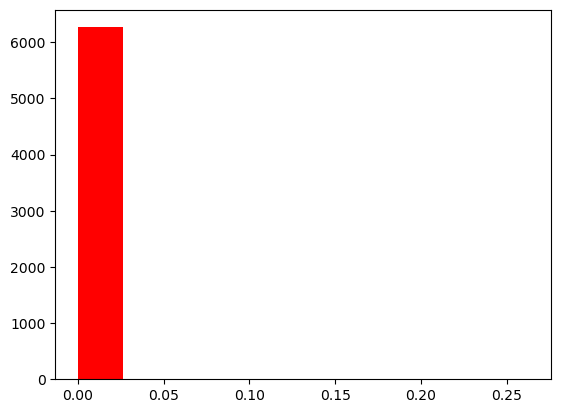

In [11]:
betweennes_degree = nx.betweenness_centrality(B)
# print("Betweenness Centrality of graph:",betweennes_degree)
plt.hist(betweennes_degree.values(),color='Red')
np.mean(list(betweennes_degree.values())), np.std(list(betweennes_degree.values()))

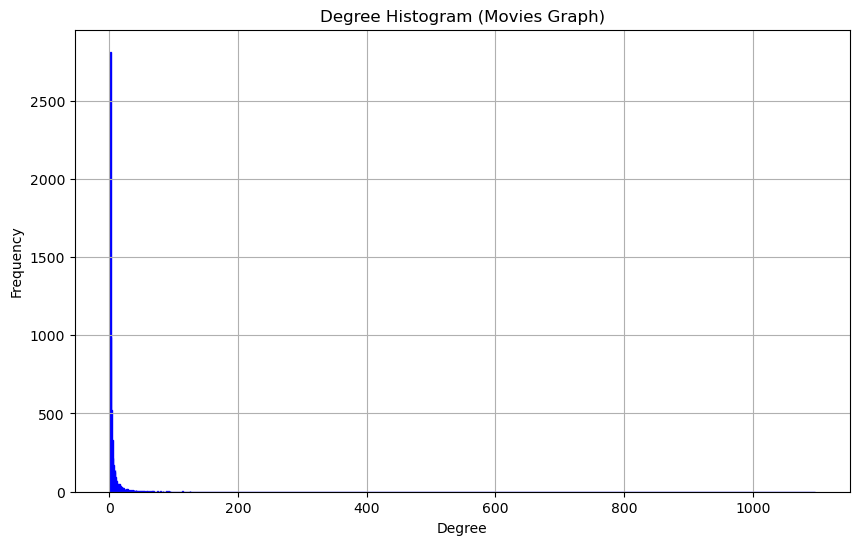

In [12]:
graph_degrees = [B.degree(n) for n in B.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(graph_degrees, bins=range(min(graph_degrees), max(graph_degrees) + 1), color='red', edgecolor='blue')
plt.title('Degree Histogram (Movies Graph)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
dendrogram = community_louvain.generate_dendrogram(B)
print("Total number of levels in the generated dendrogram are: ", len(dendrogram))

Total number of levels in the generated dendrogram are:  3


In [14]:
for dendro_level, partition in enumerate(dendrogram):
    print(f"Partition at level: {dendro_level}")
    result = community_louvain.partition_at_level(dendrogram, dendro_level)
    num_communities = len(set(result.values()))
    modularity = round(community_louvain.modularity(result, B), 3)
    print("Number of communities:", num_communities)
    print("Modularity:", modularity)

Partition at level: 0
Number of communities: 1455
Modularity: 0.239
Partition at level: 1
Number of communities: 159
Modularity: 0.374
Partition at level: 2
Number of communities: 129
Modularity: 0.377


In [15]:
for dendro_level, partition in enumerate(dendrogram[:3]):
    print("❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌")
    print("\nAnalysis for level ", dendro_level)
    result = community_louvain.partition_at_level(dendrogram, dendro_level)
    communs = {}
    for node, community_id in result.items():
        communs.setdefault(community_id, set()).add(node)
    communs_by_size = sorted(communs.values(), key=len, reverse=True)
    top_three_communs = communs_by_size[:3]
    total_communs = len(communs)
    print("Total number of communities present in the Movies network:", total_communs)
    for idx, commun_nodes in enumerate(top_three_communs, 1):
        subgraph = B.subgraph(commun_nodes)
        numOf_nodes = len(subgraph.nodes())
        numOf_edges = len(subgraph.edges())
        avg_shortest_pathOfFBG = nx.average_shortest_path_length(subgraph)
        avg_clustering_coefficientOfFBG = nx.average_clustering(subgraph)
        diameterOfFBG = nx.diameter(subgraph)
        densityOfFBG = nx.density(subgraph)
        
        print(f"\nTop Community no. {idx} at dendrogram level {dendro_level}:")
        print("Number of nodes:", numOf_nodes)
        print("Number of edges:", numOf_edges)
        print("Average shortest path length:", avg_shortest_pathOfFBG)
        print("Average clustering coefficient:", avg_clustering_coefficientOfFBG)
        print("Diameter:", diameterOfFBG)
        print("Density:", densityOfFBG)

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌

Analysis for level  0
Total number of communities present in the Movies network: 1455

Top Community no. 1 at dendrogram level 0:
Number of nodes: 225
Number of edges: 224
Average shortest path length: 1.991111111111111
Average clustering coefficient: 0.0
Diameter: 2
Density: 0.008888888888888889

Top Community no. 2 at dendrogram level 0:
Number of nodes: 132
Number of edges: 131
Average shortest path length: 1.9848484848484849
Average clustering coefficient: 0.0
Diameter: 2
Density: 0.015151515151515152

Top Community no. 3 at dendrogram level 0:
Number of nodes: 108
Number of edges: 107
Average shortest path length: 1.9814814814814814
Average clustering coefficient: 0.0
Diameter: 2
Density: 0.018518518518518517
❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌

Analysis for level  1
Total number of communities present in the Movies network: 159

Top Community no. 1 at dendrogram level 1:
Number of nodes: 697
Number of edges: 1162
Average shortest path length

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌

Analysis at level: 0
Total number of communities in the Movies Network are: 1455


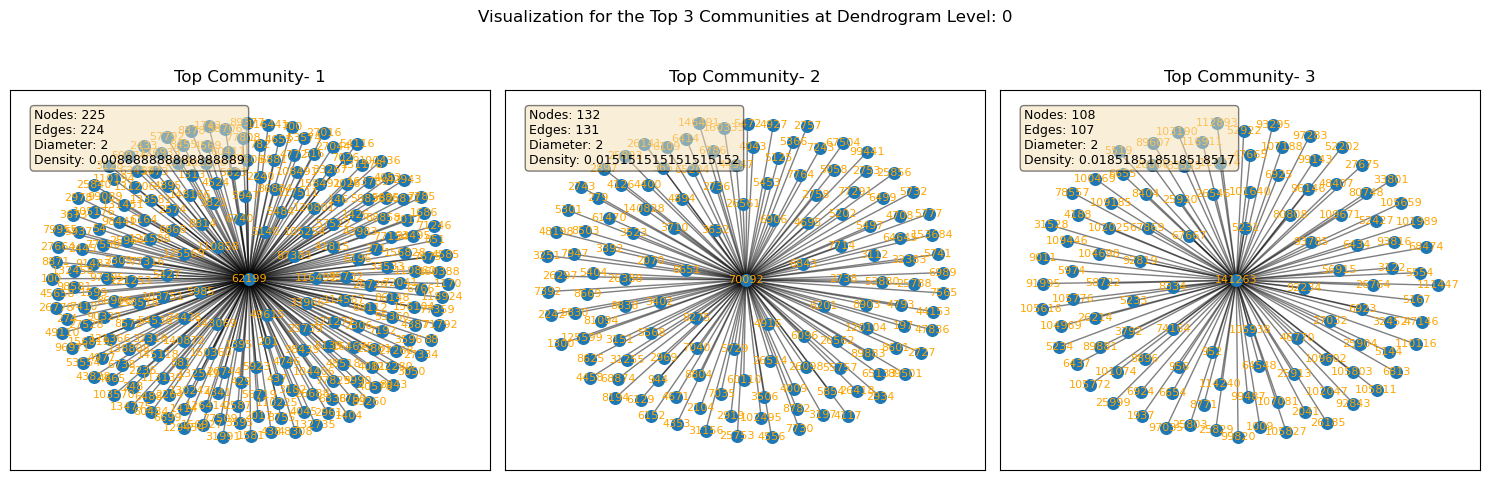

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌

Analysis at level: 1
Total number of communities in the Movies Network are: 159


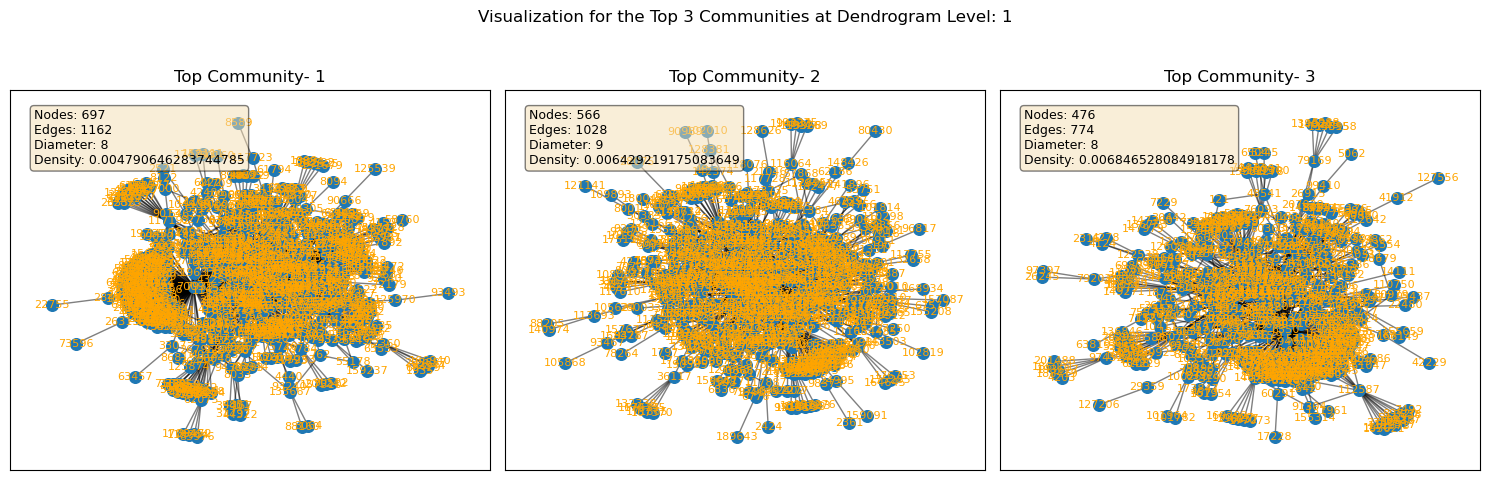

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌

Analysis at level: 2
Total number of communities in the Movies Network are: 129


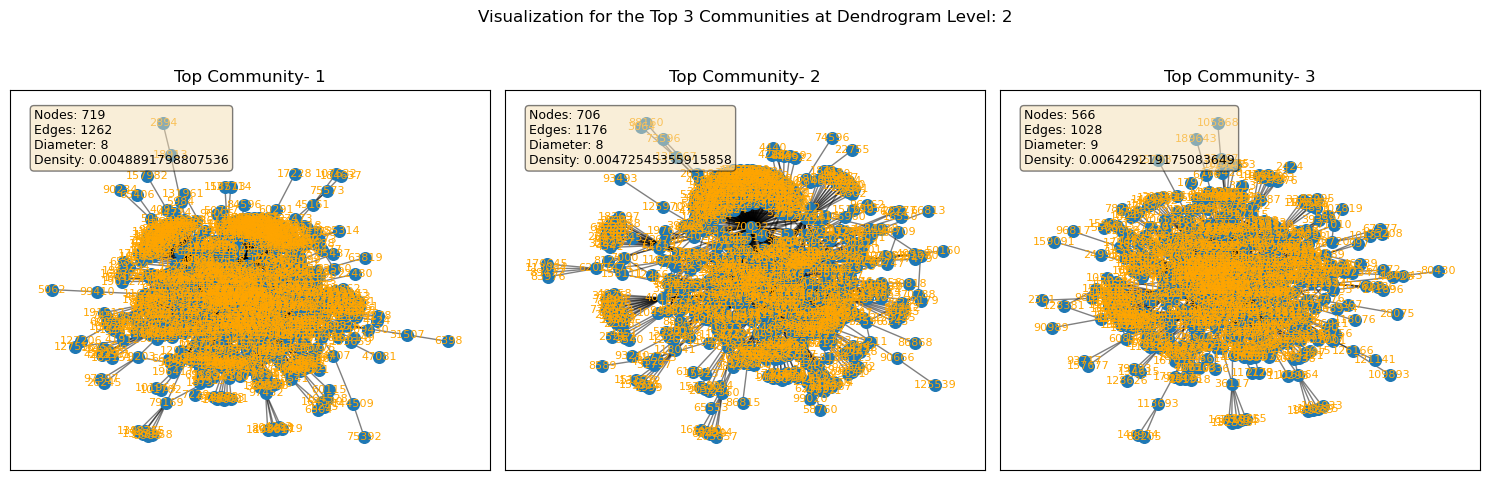

In [16]:
for dendro_level, partition in enumerate(dendrogram[:3]):
    print("❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌")
    print("\nAnalysis at level:", dendro_level)
    result = community_louvain.partition_at_level(dendrogram, dendro_level)
    communs = {}
    for node, community_id in result.items():
        communs.setdefault(community_id, set()).add(node)
    communs_by_size = sorted(communs.values(), key=len, reverse=True)
    top_three_communs = communs_by_size[:3]
    total_communs = len(communs)
    print("Total number of communities in the Movies Network are:", total_communs)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"Visualization for the Top 3 Communities at Dendrogram Level: {dendro_level}")
    
    for idx, (commun_nodes, ax) in enumerate(zip(top_three_communs, axes.flatten()), 1):
        subgraph = B.subgraph(commun_nodes)
        pos = nx.spring_layout(subgraph)  
        nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=70)
        nx.draw_networkx_edges(subgraph, pos, ax=ax, width=1.0, alpha=0.5)
        nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8, font_color='orange')
        ax.set_title(f"Top Community- {idx}")
        ax.text(0.05, 0.95, f"Nodes: {len(subgraph.nodes())}\nEdges: {len(subgraph.edges())}\nDiameter: {nx.diameter(subgraph)}\nDensity: {nx.density(subgraph)}",transform=ax.transAxes, fontsize=9,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))              
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Topic Modelling

In [17]:
data['combined'] = data['title'] + " " + data['genres'].replace('|', ' ')

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS:
            result.append(token)
    return result

data['processed'] = data['combined'].map(preprocess)
dictionary = corpora.Dictionary(data['processed'])
corpus = [dictionary.doc2bow(text) for text in data['processed']]
lda_model = models.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=4, 
                           random_state=100,
                           update_every=1,
                           chunksize=100,
                           passes=10,
                           alpha='auto',
                           per_word_topics=True)
lda_model.print_topics(num_words=5)

[(0,
  '0.082*"war" + 0.040*"film" + 0.035*"noir" + 0.035*"listed" + 0.035*"genres"'),
 (1,
  '0.121*"adventure" + 0.079*"fantasy" + 0.054*"children" + 0.053*"animation" + 0.033*"action"'),
 (2,
  '0.234*"drama" + 0.147*"comedy" + 0.086*"romance" + 0.041*"documentary" + 0.025*"musical"'),
 (3,
  '0.144*"thriller" + 0.089*"horror" + 0.083*"crime" + 0.081*"action" + 0.060*"sci"')]

## Link Prediction

In [18]:
potential_links = list(nx.non_edges(B))
random_potential_links = random.sample(potential_links, min(1000, len(potential_links)))

link_predictions = []
for node1, node2 in random_potential_links:
    shared_neighbors = len(list(nx.common_neighbors(B, node1, node2)))
    jaccard_index = round(next(nx.jaccard_coefficient(B, [(node1, node2)]))[2], 3)
    resource_alloc_index = round(next(nx.resource_allocation_index(B, [(node1, node2)]))[2], 3)
    link_predictions.append((node1, node2, shared_neighbors, jaccard_index, resource_alloc_index))

link_prediction_metrics = pd.DataFrame(link_predictions, columns=['Node_1', 'Node_2', 'Shared_Neighbors', 'Jaccard_Index', 'Resource_Allocation_Index'])

top_predictions = link_prediction_metrics.sort_values('Jaccard_Index', ascending=False).head(10)
top_predictions

,Node_1,Node_2,Shared_Neighbors,Jaccard_Index,Resource_Allocation_Index
470,67504,6109,1,1.000,0.002
428,33495,120801,1,1.000,0.001
586,167564,140818,1,0.500,0.004
972,110194,56915,1,0.500,0.001
963,79,156104,1,0.500,0.001
909,105345,8265,1,0.500,0.004
650,5301,26178,1,0.500,0.002
529,782,45106,1,0.333,0.001
424,70849,148166,1,0.333,0.001
25,1940,6488,1,0.333,0.001


## Movie Recommendation system


In [19]:
movies_df = pd.read_csv('Movies.csv')
movies_df.head()

,userId,movieId,genres,title,rating
0,3,260,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977),4.0
1,3,260,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977),4.0
2,4,1732,Comedy|Crime,"Big Lebowski, The (1998)",4.5
3,4,1732,Comedy|Crime,"Big Lebowski, The (1998)",4.5
4,4,7569,Action|Adventure|Sci-Fi|Thriller,You Only Live Twice (1967),3.5


In [20]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies_df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

sim_options = {
    'name': 'pearson',
    'user_based': False  
}
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

predictions = algo.test(testset)
rmse = round(accuracy.rmse(predictions),3)
print(f"Test RMSE: {rmse}")

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6608
Test RMSE: 0.661


In [21]:
def get_recommendations(user_id, data, algo, n=10):
    user_rated_movies = set(data[data['userId'] == user_id]['movieId'])
    
    predictions = []
    for movie_id in set(data['movieId']) - user_rated_movies:
        prediction = algo.predict(user_id, movie_id)
        predictions.append((movie_id, prediction.est))
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movie_ids = [pred[0] for pred in predictions[:n]]

    recommended_movies = data[data['movieId'].isin(top_movie_ids)][['movieId', 'title']].drop_duplicates()
    recommended_movies.set_index('movieId', inplace=True)
    recommended_movies = recommended_movies.loc[top_movie_ids].reset_index()
    return recommended_movies.to_dict(orient='records')

In [22]:
user_id = 1  
recommended_movies = get_recommendations(user_id, movies_df, algo)
print(recommended_movies)

[{'movieId': 1, 'title': 'Toy Story (1995)'}, {'movieId': 2, 'title': 'Jumanji (1995)'}, {'movieId': 3, 'title': 'Grumpier Old Men (1995)'}, {'movieId': 4, 'title': 'Waiting to Exhale (1995)'}, {'movieId': 5, 'title': 'Father of the Bride Part II (1995)'}, {'movieId': 6, 'title': 'Heat (1995)'}, {'movieId': 7, 'title': 'Sabrina (1995)'}, {'movieId': 8, 'title': 'Tom and Huck (1995)'}, {'movieId': 9, 'title': 'Sudden Death (1995)'}, {'movieId': 10, 'title': 'GoldenEye (1995)'}]


In [23]:
user_id = 4  
recommended_movies = get_recommendations(user_id, movies_df, algo)
print(recommended_movies)

[{'movieId': 13, 'title': 'Balto (1995)'}, {'movieId': 65567, 'title': 'Passengers (2008)'}, {'movieId': 36, 'title': 'Dead Man Walking (1995)'}, {'movieId': 62, 'title': "Mr. Holland's Opus (1995)"}, {'movieId': 63, 'title': "Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)"}, {'movieId': 69, 'title': 'Friday (1995)'}, {'movieId': 97, 'title': 'Hate (Haine, La) (1995)'}, {'movieId': 105, 'title': 'Bridges of Madison County, The (1995)'}, {'movieId': 125, 'title': 'Flirting With Disaster (1996)'}, {'movieId': 151, 'title': 'Rob Roy (1995)'}]


In [24]:
user_id = 225  
recommended_movies = get_recommendations(user_id, movies_df, algo)
print(recommended_movies)

[{'movieId': 150, 'title': 'Apollo 13 (1995)'}, {'movieId': 154, 'title': 'Beauty of the Day (Belle de jour) (1967)'}, {'movieId': 303, 'title': 'Quick and the Dead, The (1995)'}, {'movieId': 308, 'title': 'Three Colors: White (Trzy kolory: Bialy) (1994)'}, {'movieId': 382, 'title': 'Wolf (1994)'}, {'movieId': 426, 'title': 'Body Snatchers (1993)'}, {'movieId': 590, 'title': 'Dances with Wolves (1990)'}, {'movieId': 627, 'title': 'Last Supper, The (1995)'}, {'movieId': 680, 'title': 'Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)'}, {'movieId': 1120, 'title': 'People vs. Larry Flynt, The (1996)'}]
